# Kinetics of Fenol adsorption in activated carbon
For this experiment we prepared a set of solutions with **the same** mass of activated carbon in the same volume ($\sim 40$ mL) of phenol at $200$ ppm.  
(Note that in this context ppm = mg/L)  
The measurments of the residual phenol where obtained at different points in time.


## Task 0: Prepare Solutions
For this experiment we just preperaed the samples of $70mg$ of activated carbon and $40mL$ of phenol at $200ppm$.  
The measurment was then performed by the laboratory at the requested hours
We then got the data as follows

In [1]:
import csv
import numpy as np
from tabulate import tabulate

# Read CSV
file_path = './Lab 2 Data/kinetics_samples.csv'
with open(file_path, mode='r') as file:
    reader = csv.reader(file)
    rows = list(reader)

# Process header (skip first column)
header_raw = rows[0][1:]
header = [h.strip() for h in header_raw]

# Clean variable names (up to the first bracket)
var_names = []
for h in header:
    base = h.split('[')[0].strip().replace('-', '_')
    if base and base.isidentifier():
        var_names.append(base)
    else:
        raise ValueError(f"Invalid header: '{h}'")

# Convert the data block (excluding first column) to float NumPy array
data = np.array([[float(val) for val in row[1:len(var_names)+1]] for row in rows[1:]])

# Assign each column to a variable
for i, name in enumerate(var_names):
    globals()[name] = data[:, i]

# Print table for reference
print(tabulate(rows[1:], headers=rows[0], tablefmt="grid"))


+--------+----------------+--------------------+---------------------------+---------+
| name   |    mass_carbon |    solution_volume |    residual_concentration |    time |
+========+================+====================+===========================+=========+
| B      |          0.066 |           0.0402   |                    187.1  |     2   |
+--------+----------------+--------------------+---------------------------+---------+
| A      |          0.07  |           0.04     |                    146    |     4   |
+--------+----------------+--------------------+---------------------------+---------+
| F      |          0.067 |           0.04     |                    130.81 |     6   |
+--------+----------------+--------------------+---------------------------+---------+
| E      |          0.075 |           0.0401   |                    123.08 |     7.5 |
+--------+----------------+--------------------+---------------------------+---------+
| D      |          0.072 |           0.039

## Task 1: Data Analysis

#### Evaluate the mass of absorbed phenol per mass of carbon
Exactly as it was done in the Adsorption-Desorption experiment in which we changed the mass of carbon:
$$
F_{abs} = (C_i - C_f) \cdot \frac{V}{m_c}
$$
where:  
- $C_i$: Initial concentration [ppm]
- $C_f$: Final concentration measured [ppm]
- $V$: Volume of the solution [L]
- $m_c$: Mass of carbon [mg]

In [2]:
volumes = solution_volume
mass_carbon_mg = mass_carbon * 1000 # convert to mg
F_abs = (200 - residual_concentration ) * volumes / (mass_carbon_mg)

# Show a table of the results
print("\nResults:")
results = np.column_stack((rows[1:], F_abs))
rows[0].append("F_abs")
print(tabulate(results, headers=rows[0], tablefmt="grid"))



Results:
+--------+----------------+--------------------+---------------------------+---------+------------+
| name   |    mass_carbon |    solution_volume |    residual_concentration |    time |      F_abs |
+========+================+====================+===========================+=========+============+
| B      |          0.066 |           0.0402   |                    187.1  |     2   | 0.00785727 |
+--------+----------------+--------------------+---------------------------+---------+------------+
| A      |          0.07  |           0.04     |                    146    |     4   | 0.0308571  |
+--------+----------------+--------------------+---------------------------+---------+------------+
| F      |          0.067 |           0.04     |                    130.81 |     6   | 0.0413075  |
+--------+----------------+--------------------+---------------------------+---------+------------+
| E      |          0.075 |           0.0401   |                    123.08 |     7.5 | 0.0

#### Plot and fit
In this case there was no weird result to exclude

In [3]:
# Remove the discarded point from the arrays
measurement_g = residual_concentration  / 1000 # mg/L --> g/L
# measurement_clean = np.delete(measurement_g, i_discard)
# F_abs_clean = np.delete(F_abs, i_discard)

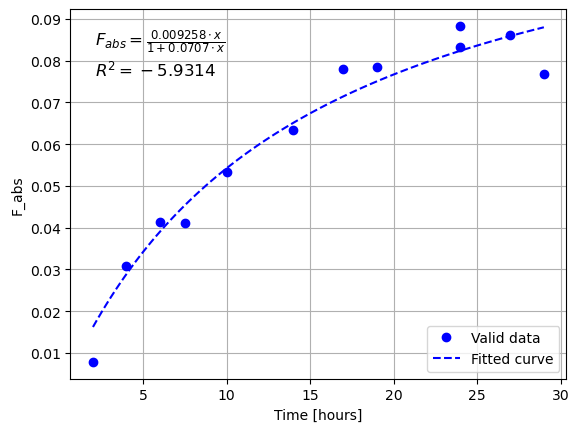

In [5]:
import matplotlib.pyplot as plt

# Plot all valid points 
plt.plot(time, F_abs, 'bo', label='Valid data')


# Fit to a power law
from scipy.optimize import curve_fit

# --- Fit to power law ---
def asymptotic_curve(x, a, b):
    return (a * x) / (1 + b*x)

# Perform the fit
params, covariance = curve_fit(asymptotic_curve, time , F_abs)
a, b = params

# Predict fitted values
F_abs_pred = asymptotic_curve(F_abs , a, b)

# Compute R² manually
ss_res = np.sum((F_abs   - F_abs_pred) ** 2)
ss_tot = np.sum((F_abs   - np.mean(F_abs)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

# Generate fitted curve
x_fit = np.linspace(min(time), max(time), 100)
y_fit = asymptotic_curve(x_fit, a, b)

# Plot the fitted curve
plt.plot(x_fit, y_fit, 'b--', label='Fitted curve')

# Annotate equation and R² on the plot
eq_text = (
    rf"$F_{{abs}} = \frac{{{a:.4g} \cdot x}}{{1 + {b:.4f} \cdot x}}$"
    f"\n$R^2 = {r_squared:.4f}$"
)
plt.text(0.05, 0.95, eq_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')

# Labels and legend
plt.xlabel("Time [hours]")
plt.ylabel("F_abs")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Compute adsorption and desorption rates
We can evaluate them by assuming an isotherm model at equilibrium, for the sake of simplicity let's do linear model.

Extract form the notes:

In non equilibrium the rate of adsorption and desorprtion are not equal, therefore we can write:
$$
\rho \cancel{V} \frac{dF_{abs}}{dt} = \dot{D} F_{abs} \rho  \cancel{V} - \dot{A} C n \cancel{V}
$$
Desorption (from solid to solution) rate by the mass of solid minus the adsorption (solution to solid) rate by the mass of solution.  
In steady state the time derivative is zero and the two rates balance out.  
This means that in non equilibrium conditions we have 2 more unkowns. To simplify the problem we can assume that the ratio between adsorptin and desorption at steady state is the same also at non equilibrium conditions.  

$$
\text{Non equilibrium: } \rho \frac{dF_{abs}}{dt} = \dot{D} F_{abs} \rho_{solid} - \dot{A} C n  \\
\text{Equilibrium: } 0 = \dot{D} F_{abs} \rho - \dot{A} C n 
$$
We can substitute an isotherm in the equilibrium case, we assume a linear model for semplicity $F_{abs} = K_1 C$.    
$$
\dot{D} K_1 \cancel{C} \rho = \dot{A} \cancel{C} n
$$
So that we can express one of the rates in terms of the other and substitute in the first one.  
$$
\dot{D} = \frac{\dot{A} n}{K_1 \rho} \\
\rho \frac{dF_{abs}}{dt} = \frac{\dot{A} n}{K_1 \rho} F_{abs} \rho - \dot{A} C n
$$

So if we explicit $\dot{A}$ we get:
$$
\dot{A} = \rho \left( \frac{dF_{abs}}{dt} \right) \frac{1}{n\left( \frac{F_{abs}}{K_1} - C \right)}
$$

We have to assume some missing data, namely the porosity of the activated carbon and its density, those are likely available but at the time of makeing this report I could not find any information

$K_1$ from the linear model should be obtained by fitting a linear relationship. In this case i would proprose to break up into 3 linear sections to obtain a decent fit:
- Between 0 and 7
- Between 7 and 20
- Between 20 and the end 
   
Here i just assume a value by looking at the inclination of the first points

In [11]:
density = 1500 # g/L
porosity = 0.5 # -
K1 = 0.006

In [16]:
# get the derivative of the fitted curve
from scipy.misc import derivative
def fitted_derivative(x):
    return derivative(lambda x: asymptotic_curve(x, a, b), x, dx=1e-6)

# Evaluate the adsorption rate for each measurement
ads_rates = []
for i, c in enumerate(residual_concentration/1000):
    t = time[i]
    adsorption_rate = density * fitted_derivative(t) / (porosity * (F_abs[i] / K1 - c))
    ads_rates.append(adsorption_rate)

C:\Users\Simo\AppData\Local\Temp\ipykernel_24252\2336923220.py:4: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: asymptotic_curve(x, a, b), x, dx=1e-6)


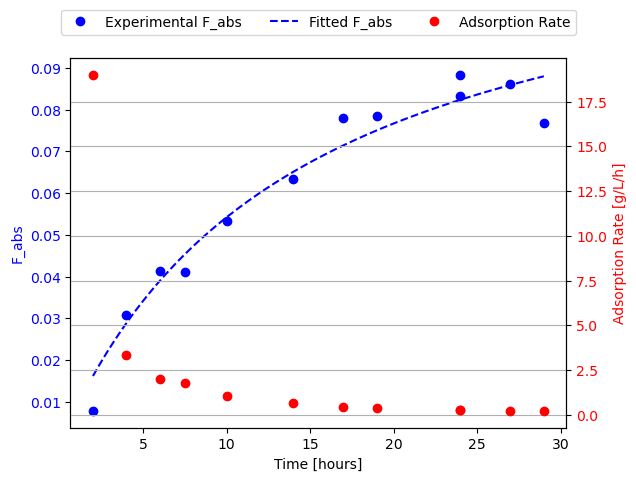

In [20]:
# Plot the adsorption rates
fig, ax1 = plt.subplots()

# Plot F_abs and fitted curve on left y-axis
ax1.plot(time, F_abs, 'bo', label='Experimental F_abs')
ax1.plot(x_fit, y_fit, 'b--', label='Fitted F_abs')
ax1.set_xlabel("Time [hours]")
ax1.set_ylabel("F_abs", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for adsorption rate
ax2 = ax1.twinx()
ax2.plot(time, ads_rates, 'ro', label='Adsorption Rate')
ax2.set_ylabel("Adsorption Rate [g/L/h]", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

plt.grid(True)
plt.show()
